In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
profile_res = pd.read_csv('profile_res/profiling_bert_res.csv')
profile_res

,embed_layer,transformer_layer_0,transformer_layer_1,transformer_layer_2,transformer_layer_3,transformer_layer_4,transformer_layer_5,transformer_layer_6,transformer_layer_7,transformer_layer_8,transformer_layer_9,transformer_layer_10,transformer_layer_11
0,0.000988,0.324938,0.002316,0.002047,0.002275,0.002086,0.002288,0.002043,0.002250,0.002037,0.002263,0.002016,0.002619
1,0.000217,0.000720,0.000684,0.000673,0.000677,0.000691,0.000674,0.000670,0.000668,0.000668,0.000680,0.000661,0.000661
2,0.000171,0.001305,0.000983,0.000989,0.001006,0.000970,0.000961,0.000987,0.000964,0.000978,0.000961,0.000982,0.000986
3,0.000179,0.000736,0.000699,0.000676,0.000676,0.000677,0.000674,0.000665,0.000688,0.000663,0.000661,0.000663,0.000666
4,0.000169,0.000698,0.000690,0.000667,0.000661,0.000674,0.000666,0.000670,0.000687,0.000666,0.000669,0.000657,0.000652
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000175,0.000712,0.000666,0.000664,0.000660,0.000668,0.000666,0.000695,0.000668,0.000666,0.000661,0.000663,0.000660
4996,0.000211,0.001036,0.000835,0.000923,0.000830,0.000841,0.000835,0.000839,0.000972,0.000854,0.001103,0.000842,0.000856
4997,0.000235,0.000936,0.000926,0.000918,0.000917,0.000917,0.000937,0.000920,0.000920,0.000923,0.000931,0.000917,0.000919
4998,0.000228,0.000936,0.000932,0.000924,0.000949,0.000928,0.000934,0.000926,0.000937,0.000931,0.000928,0.000926,0.000937


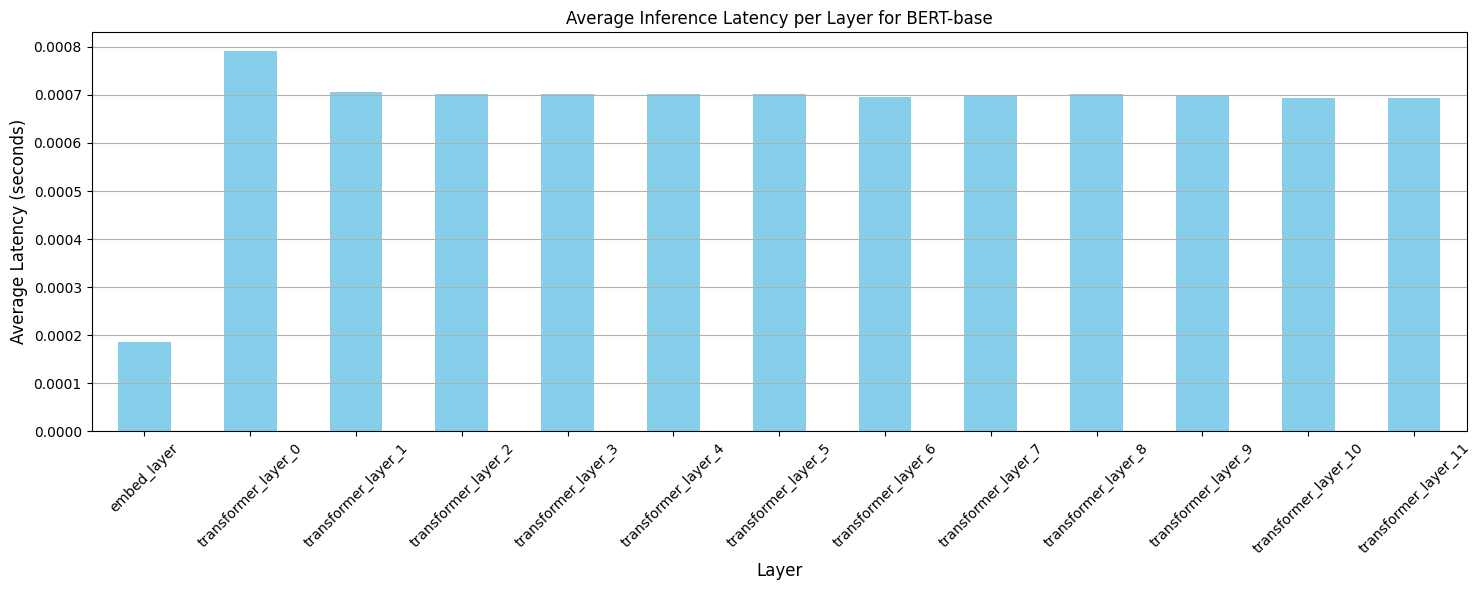

In [10]:
# Plot the average latency distribution of each layer
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame loaded as df
averages = profile_res.mean()

# Plotting
plt.figure(figsize=(15, 6))
averages.plot(kind='bar', color='skyblue')
plt.ylabel('Average Latency (seconds)', fontdict={'fontsize': 12})
plt.xlabel('Layer', fontdict={'fontsize': 12})
plt.title('Average Inference Latency per Layer for BERT-base')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
